In [2]:
#show line numbers 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


/var/folders/xh/ptx1dfmx2m7946z7pr5dn7ph0000gn/T/ipykernel_18925/1686969377.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [1]:
!python -m pip install --upgrade pip

In [16]:
!pip3 install torch torchvision torchaudio

In [17]:
!pip install --upgrade torch torchvision

In [18]:
!pip3 install opencv-python

In [19]:
!pip3 install -U scikit-learn scipy matplotlib

In [7]:
!brew install unrar
!brew install rar

==> Downloading https://formulae.brew.sh/api/formula.jws.json
#=#=#                                                                          
==> Downloading https://formulae.brew.sh/api/cask.jws.json
#=#=#                                                                          
==> Searching for similarly named formulae and casks...
==> Formulae
unar

To install unar, run:
  brew install unar

==> Casks
lunar

To install lunar, run:
  brew install --cask lunar

To re-install rar, run:
  brew reinstall --cask rar


In [ ]:
!sudo apt-get install unrar

In [ ]:
!unzip EFPDS-Frames.zip

In [ ]:
#get UCF101 data

!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar

In [ ]:
!unrar x UCF101.rar -y

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import cv2

import time
import os
import shutil
import copy
import math
import random
import numpy as np
import datetime as dt

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# check pytorch version
print(torch.__version__)

2.0.1


In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)

In [ ]:
# BELOW IS FOR USE WITH UCF-101

In [5]:
data_dir = 'UCF-101'
frame_dir = 'UCF-101-Frames'

#make folder for frame_dir if it doesn't exist
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)

# Get Names of all classes in UCF50
all_classes_list = os.listdir('UCF-101')
classes_list = ["PullUps", "JumpingJack", "HighJump"]

In [6]:
#Frame Extraction  -  January 11/2023! Less goooo

for class_name in classes_list:
    videos_list = os.listdir(os.path.join(data_dir, class_name))
    for video_name in videos_list:
        # Open the video
        video_file_path = os.path.join(data_dir, class_name, video_name)
        cap = cv2.VideoCapture(video_file_path)

        # Extract the frames for each class
        frame_count = 0
        while True:
            # Read the next frame
            ret, frame = cap.read()

            if not ret:
                break

            # See if folder for class exists, if not make one
            class_folder_path = os.path.join(frame_dir, class_name)
            if not os.path.exists(class_folder_path):
                os.makedirs(class_folder_path)
            
            # Save the frame to disk
            cv2.imwrite(os.path.join(frame_dir, class_name, f'{video_name}_frame_{frame_count}.jpg'), frame)
                        
            frame_count += 1

        # Release the video capture
        cap.release()

KeyboardInterrupt: 

In [50]:
# BELOW IS FOR USE WITH EFPDS DATASET

In [4]:
def get_folders(path):
    return [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]


In [5]:
data_dir = 'EFPDS'
frame_dir = 'EFPDS-Frames'

#make folder for frame_dir if it doesn't exist
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)

classes_list = ["Fall", "No Fall"]
all_classes_list = get_folders(frame_dir)
print(all_classes_list)

for class_item in classes_list:
    class_dir = os.path.join(frame_dir, class_item)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

['No Fall', 'Fall']


In [9]:
data_sub_dir_list = ['train 3', 'valid', 'test']

# if a video contains even one fallen person, it is classified as 'fall'

for sub_dir in data_sub_dir_list:
    data_sub_dir = os.path.join(data_dir, sub_dir)
    for split in get_folders(data_sub_dir):
        data_split_dir = os.path.join(data_sub_dir, split)
        for file in os.listdir(data_split_dir):
            if file.endswith("png"):
                file_dir = os.path.join(data_split_dir, file)
                file_info_dir = os.path.splitext(file_dir)[0] + ".txt"
                did_file_moved = False
                with open(file_info_dir, 'r') as file: #with ensures that the file is closed after reading
                    current_line = file.readline()
                    while current_line:
                        file_value = current_line.split(" ")[0]
                        if int(file_value) == 1:
                            shutil.move(file_dir, os.path.join(frame_dir, classes_list[0]))
                            did_file_moved = True
                            break
                        else:
                            current_line = file.readline()
                if not did_file_moved:
                    shutil.move(file_dir, os.path.join(frame_dir, classes_list[1]))
                
        

In [10]:
#############################################
# CALCULATE MEAN AND STD FOR DATATRANSFORMS #
#############################################
# image_dataset = datasets.ImageFolder(frame_dir)

# # Initialize a placeholder tensor to store all images in the dataset
# # Get the shape of the first image 
# sample_transformed_image = transforms.ToTensor()(image_dataset[0][0])
# image_shape = sample_transformed_image.shape

# # Initialize the placeholder tensor using the shape of the images
# all_images = torch.empty(size=(len(image_dataset), 3, *image_shape))

# # Iterate over the dataset and add each image to the placeholder tensor
# for i, (image, label) in enumerate(image_dataset):
#     all_images[i] = transforms.ToTensor()(image)

# # Calculate mean and std
# mean = torch.mean(all_images, dim=(0, 2, 3))
# std = torch.std(all_images, dim=(0, 2, 3))

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation

height, width = 200,200 # 480, 640 efpds
data_transforms = transforms.Compose([
        transforms.CenterCrop((height, width)), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image_dataset = datasets.ImageFolder(frame_dir, transform = data_transforms)#dataset of ALL theframes

train_dataset_size = int(len(image_dataset) * 0.8)
valid_dataset_size = len(image_dataset) - train_dataset_size
train_dataset, valid_dataset = data.random_split(image_dataset, [train_dataset_size, valid_dataset_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                             shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16,
                                             shuffle=True, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Update classes_list to match the order of the folders

classes_list = image_dataset.classes

tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0])


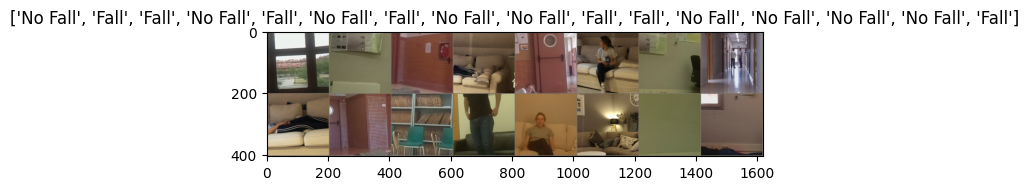

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
dataiter = iter(train_dataloader)
batch = next(dataiter)
inputs, classes = batch
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes_list[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
                #set totrain dataloader and dataset size
                dataloader = train_dataloader
                dataset_size = train_dataset_size
                
            else:
                model.eval()   # Set model to evaluate mode
                
                #set to validation dataloader and dataset size
                dataloader = valid_dataloader
                dataset_size = valid_dataset_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [20]:
def visualize_model(model, num_images=3):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_list[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
#model_ft = torch.load("actionRecognitionModel.pt", map_location=torch.device('cpu'))
model_ft = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
model_ft.eval()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to amount of classes
model_ft.fc = nn.Linear(num_ftrs, len(classes_list))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Using cache found in /Users/davidjr/.cache/torch/hub/pytorch_vision_main


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.3017 Acc: 0.8789
val Loss: 0.1369 Acc: 0.9554

Training complete in 48m 10s
Best val Acc: 0.955428


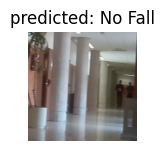

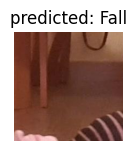

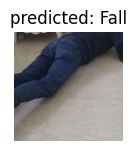

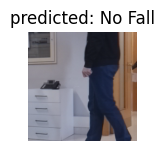

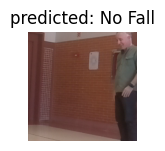

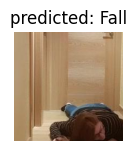

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8f33773550>
Traceback (most recent call last):
  File "/Users/davidjr/ImageClassification/imageclassification/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/davidjr/ImageClassification/imageclassification/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/davidjr/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/davidjr/opt/anaconda3/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/davidjr/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/Users/davidjr/opt/anaconda3/lib/python3.9/selectors.py", line 416, i

In [19]:
visualize_model(model_ft)

In [14]:
model_path = 'actionRecognitionModel.pt'

# save the model's state dictionary to the file
torch.save(model_ft.state_dict(), model_path)

In [ ]:
# initialize video capture object for webcam
cap = cv2.VideoCapture(0)

# define the size of the resized frame
frame_size = (480,640)

# set model to evaluation mode
model_ft.eval()

while True:
    # capture frame-by-frame
    ret, frame = cap.read()

    if ret:
        # resize the frame to a fixed size
        frame = cv2.resize(frame, frame_size)

        # convert the frame to a PyTorch tensor
        tensor_frame = torch.from_numpy(np.expand_dims(frame.transpose((2, 0, 1)), axis=0)).float().div(255)

        # pass the tensor through the model to get the predictions
        with torch.no_grad():
            outputs = model_ft(tensor_frame)
            _, preds = torch.max(outputs, 1)
            print(f'predicted: {classes_list[preds[0]]}')

        # display classified frame
        cv2.imshow('Live Video Classification', frame)

    # exit loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release video capture object and close windows
cap.release()
cv2.destroyAllWindows()
